In [1]:
from  qblockchain import QBlockchain



In [ ]:
!pip install qiskit_ibm_provider

In [5]:
from qiskit_ibm_provider import IBMProvider
#IBMProvider.save_account(token='27fdaebc9a8a896456073416d8cac307a5daafc90c0bf559dd7df7483de06a9665f5165abc7e468554b79308ad563448e9fc1ba98caa8660983da827a9320dd1')


#provider = IBMProvider(instance="ibm-q/open/main")
provider = IBMProvider()

# display current supported backends
#print(provider.backends())



In [6]:
# get IBM's simulator backend
simulator_backend = provider.get_backend('ibmq_qasm_simulator')
print(simulator_backend.name)

ibmq_qasm_simulator


In [11]:
# import modules for SHA
import sys
import hashlib
import random

if sys.version_info < (3, 6):
	import sha3

# import modules for Qiskit
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import BasicAer, Aer, IBMQ, execute, schedule
from qiskit.compiler import transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.transpiler import PassManager
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer import AerSimulator
# from azure.quantum.qiskit import AzureQuantumProvider

# import other useful packages 
from numpy import pi
from datetime import date
import time

In [12]:
# input parameters
previous_hash = '' #empty hash
block_number = 0
numberOfBlocks = 1
errors = 0 #number of 'False' nonces
difficulty = 1 #number of prefix zeros (hash-problem difficulty)
transactions ='Schroedinger paid Einstein 1 qBTC'
MAX_NONCE = 2**32
QC_switch = 1 #0 - simulator, 1 - real QC
n_qreg = 3 #number of qubits

In [9]:
# setting the quantum circuit:
def quantum_circuit(q_par, n_qreg):
        qreg_q = QuantumRegister(n_qreg, 'q')
        creg_c = ClassicalRegister(n_qreg, 'c')
        circuit = QuantumCircuit(qreg_q, creg_c)

        #repetitive circuit
#         for i in range(circ_layer):
            
        #n-qubit circuit  
        k = 0 #counter for the parameter values
        for i in range(n_qreg):   
            circuit.rx(q_par[k+i]*pi/8, qreg_q[i])
        k+=n_qreg
        
        for i in range(n_qreg):    
            circuit.rz(q_par[k+i]*pi/8, qreg_q[i])
        k+=n_qreg
        
        for i in range(n_qreg):
            for j in range(n_qreg):
                if j != i:
                    circuit.crx(q_par[k+j]*pi/8, qreg_q[n_qreg-1-i], qreg_q[n_qreg-1-j])
                else:
                    k-=1
            k+=n_qreg-1
        
        for i in range(n_qreg):   
            circuit.rx(q_par[k+i]*pi/8, qreg_q[i])
        k+=n_qreg
        
        for i in range(n_qreg):    
            circuit.rz(q_par[k+i]*pi/8, qreg_q[i])

        #measurements of all qubits
        for i in range(len(qreg_q)):
            circuit.measure(qreg_q[i], creg_c[i])
        
        return circuit

In [10]:
circuit1 = quantum_circuit((2,3,1,2,1,1,1,1),2)
circuit1.draw()

┌─────────┐ ┌─────────┐┌─────────┐           ┌─────────┐┌─────────┐┌─┐   
q_0: ┤ Rx(π/4) ├─┤ Rz(π/8) ├┤ Rx(π/8) ├─────■─────┤ Rx(π/8) ├┤ Rz(π/8) ├┤M├───
     ├─────────┴┐├─────────┤└────┬────┘┌────┴────┐├─────────┤├─────────┤└╥┘┌─┐
q_1: ┤ Rx(3π/8) ├┤ Rz(π/4) ├─────■─────┤ Rx(π/8) ├┤ Rx(π/8) ├┤ Rz(π/8) ├─╫─┤M├
     └──────────┘└─────────┘           └─────────┘└─────────┘└─────────┘ ║ └╥┘
c: 2/════════════════════════════════════════════════════════════════════╩══╩═
                                                                         0  1

## Run a single experiment
Use Sampler to determine the quasi-probability distribution of a single circuit

In [13]:
from qiskit.circuit.random import random_circuit
from qiskit.primitives import Sampler

circuit = random_circuit(2, 2, seed=1).decompose(reps=1)
circuit.measure_all()



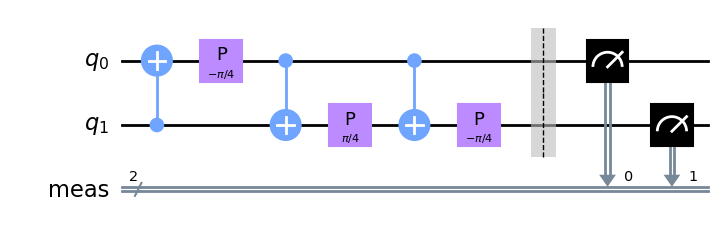

 > Quasi probability distribution: {0: 0.4035581078975822, 1: 0.1182586782311416, 2: 0.2426562782303414, 3: 0.2355269356409344}
 > Metadata: {}


In [11]:
sampler = Sampler()
job = sampler.run(circuit1)
result = job.result()

display(circuit.draw("mpl"))
print(f" > Quasi probability distribution: {result.quasi_dists[0]}")
print(f" > Metadata: {result.metadata[0]}")

## Run multiple experiments in a single job
Use Sampler to determine the quasi-probability distributions of multiple circuits in one job

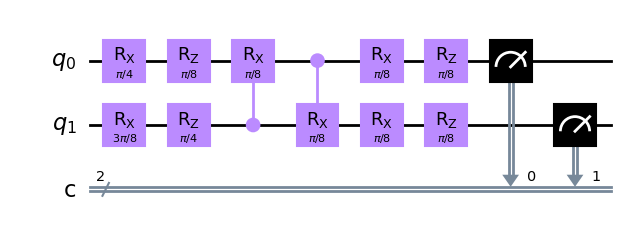

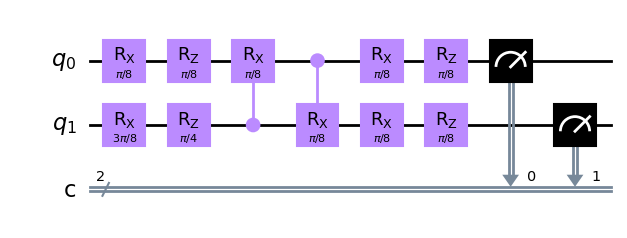

 > Quasi probability distributions: [{0: 0.4035581078975822, 1: 0.1182586782311416, 2: 0.2426562782303414, 3: 0.2355269356409344}, {0: 0.4879533559627626, 1: 0.0553906027342485, 2: 0.3254897333731378, 3: 0.1311663079298508}]
 > Metadata: [{}, {}]


In [18]:
from qiskit.circuit.random import random_circuit
from qiskit.primitives import Sampler

circuits = (
    quantum_circuit((2,3,1,2,1,1,1,1),2),
    quantum_circuit((1,3,1,2,1,1,1,1),2),
)


sampler = Sampler()
job = sampler.run(circuits)
result = job.result()

[display(cir.draw("mpl")) for cir in circuits]
print(f" > Quasi probability distributions: {result.quasi_dists}")
print(f" > Metadata: {result.metadata}")

In [24]:
hashIn = hashlib.sha3_256("shatoshi nakamoto".encode("ascii")).hexdigest() # hashing the 'text' input

print ('hashIn-hex:', hashIn, 'length:', len(hashIn))

# convert hashIn(hex) to hashIn_bin(binary)
scale = 16 #hex base
hashIn_bin = bin(int(hashIn, scale))[2:].zfill(len(hashIn)*4)
print(hashIn_bin)
print ('hashIn-binary:', str(hashIn_bin), 'length:', len(hashIn_bin))

hashIn-hex: f029113602678a9a982e452009a049422fdf315c0592e0c334020094a129a2b4 length: 64
1111000000101001000100010011011000000010011001111000101010011010100110000010111001000101001000000000100110100000010010010100001000101111110111110011000101011100000001011001001011100000110000110011010000000010000000001001010010100001001010011010001010110100
hashIn-binary: 1111000000101001000100010011011000000010011001111000101010011010100110000010111001000101001000000000100110100000010010010100001000101111110111110011000101011100000001011001001011100000110000110011010000000010000000001001010010100001001010011010001010110100 length: 256


In [8]:
from qblockchain import QBlockchain

bc = QBlockchain("qasm_simulator")

In [9]:
bc.mine_block("uhh")
bc.is_chain_valid()

True

hashIn-hex: c7c2c714578c88e65f82f1f12298ec860c81ea840682775ed07adb8e52405d31 length: 64
hashIn-binary: 1100011111000010110001110001010001010111100011001000100011100110010111111000001011110001111100010010001010011000111011001000011000001100100000011110101010000100000001101000001001110111010111101101000001111010110110111000111001010010010000000101110100110001 length: 256
hashIn binary split into 4bit bins: ['0001', '1111', '0000', '1011', '0001', '1100', '0101', '0001', '0101', '1110', '0011', '0010', '0010', '0011', '1001', '1001', '0111', '1110', '0000', '1011', '1100', '0111', '1100', '0100', '1000', '1010', '0110', '0011', '1011', '0010', '0001', '1000', '0011', '0010', '0000', '0111', '1010', '1010', '0001', '0000', '0001', '1010', '0000', '1001', '1101', '1101', '0111', '1011', '0100', '0001', '1110', '1011', '0110', '1110', '0011', '1001', '0100', '1001', '0000', '0001', '0111', '0100', '1100', '01']
[1, 15, 0, 11, 1, 12, 5, 1, 5, 14, 3, 2, 2, 3, 9, 9, 7, 14, 0, 11, 12, 7, 12, 4, 

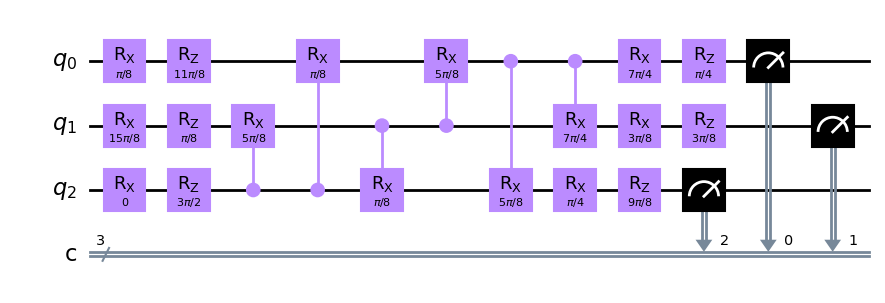

In [16]:
transfBit = bc.string_to_bitlist("uhti")
circ1 = bc.quantum_circuit(transfBit,3)
display(circ1.draw("mpl"))


In [30]:

text = "0000000"  
hashIn = hashlib.sha3_256(text.encode("ascii")).hexdigest() # hashing the 'text' input
print ('hashIn-hex:', hashIn, 'length:', len(hashIn))  

# convert hashIn(hex) to hashIn_bin(binary)
scale = 16 #hex base
hashIn_bin = bin(int(hashIn, scale))[2:].zfill(len(hashIn)*4)
print ('hashIn-binary:', str(hashIn_bin), 'length:', len(hashIn_bin))
 
#input hashIn string
fourbit_array = bc.break_up_4bit_values(hashIn_bin)
    
q_par = [int(fourbit_array[i],2) for i in range(len(fourbit_array)-1)] #throwing away the last string element
print(q_par)
    
assert type(q_par) == list
circuit = bc.quantum_circuit(q_par=q_par)

hashIn-hex: 59e7e35b4702404657176d532f908936c0bcc675cb259504a9cffcf0048fa61b length: 64
hashIn-binary: 0101100111100111111000110101101101000111000000100100000001000110010101110001011101101101010100110010111110010000100010010011011011000000101111001100011001110101110010110010010110010101000001001010100111001111111111001111000000000100100011111010011000011011 length: 256
hashIn binary split into 4bit bins: ['0110', '0111', '1001', '1111', '1000', '1101', '0110', '1101', '0001', '1100', '0000', '1001', '0000', '0001', '0001', '1001', '0101', '1100', '0101', '1101', '1011', '0101', '0100', '1100', '1011', '1110', '0100', '0010', '0010', '0100', '1101', '1011', '0000', '0010', '1111', '0011', '0001', '1001', '1101', '0111', '0010', '1100', '1001', '0110', '0101', '0100', '0001', '0010', '1010', '0111', '0011', '1111', '1111', '0011', '1100', '0000', '0001', '0010', '0011', '1110', '1001', '1000', '0110', '11']
[6, 7, 9, 15, 8, 13, 6, 13, 1, 12, 0, 9, 0, 1, 1, 9, 5, 12, 5, 13, 11, 5, 4, 12, 

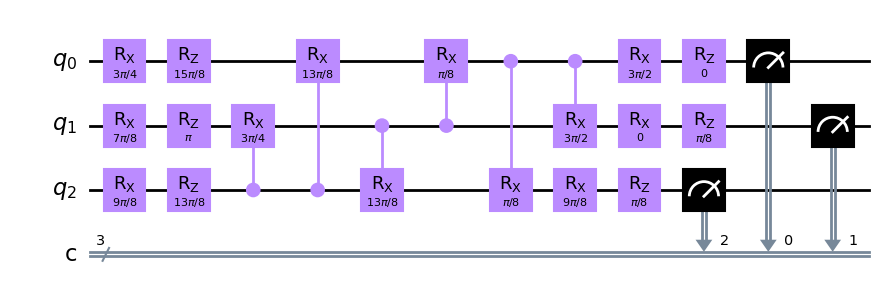

 > Quasi probability distribution: {0: 0.0671778554021385, 1: 0.7338653591453504, 2: 0.0808348076196192, 3: 0.0116639067596896, 4: 0.0174532271721264, 5: 0.0374221021500581, 6: 0.0144697864850248, 7: 0.0371129552659929}
 > Metadata: {}


In [32]:
sampler = Sampler()
job = sampler.run(circuit)
result = job.result()

display(circuit.draw("mpl"))
print(f" > Quasi probability distribution: {result.quasi_dists[0]}")
print(f" > Metadata: {result.metadata[0]}")

In [ ]:
circuits = (
    bc.quantum_circuit(bc.string_to_bitlist("uhti"),3),
    bc.quantum_circuit(bc.string_to_bitlist("ahti"),3),
)


sampler = Sampler()
job = sampler.run(circuits)
result = job.result()

[display(cir.draw("mpl")) for cir in circuits]
print(f" > Quasi probability distributions: {result.quasi_dists}")
print(f" > Metadata: {result.metadata}")

In [3]:
from qiskit_ibm_runtime import Session, Sampler, Estimator



In [ ]:
from qiskit.quantum_info import SparsePauliOp
observable = SparsePauliOp("XZ")
print(f">>> Observable: {observable.paulis}")

In [35]:
circuits = []

for i in range(3):
    circuits.append(bc.quantum_circuit(bc.string_to_bitlist("uhti"+str(i)),3))
    



hashIn-hex: e626e2125b2176aecf5e26b4c8678cbf9e04301c2d4ef74af9ac5e47d9665cc4 length: 64
hashIn-binary: 1110011000100110111000100001001001011011001000010111011010101110110011110101111000100110101101001100100001100111100011001011111110011110000001000011000000011100001011010100111011110111010010101111100110101100010111100100011111011001011001100101110011000100 length: 256
hashIn binary split into 4bit bins: ['1001', '1000', '1001', '1011', '1000', '1000', '0100', '1001', '0110', '1100', '1000', '0101', '1101', '1010', '1011', '1011', '0011', '1101', '0111', '1000', '1001', '1010', '1101', '0011', '0010', '0001', '1001', '1110', '0011', '0010', '1111', '1110', '0111', '1000', '0001', '0000', '1100', '0000', '0111', '0000', '1011', '0101', '0011', '1011', '1101', '1101', '0010', '1011', '1110', '0110', '1011', '0001', '0111', '1001', '0001', '1111', '0110', '0101', '1001', '1001', '0111', '0011', '0001', '00']
[9, 8, 9, 11, 8, 8, 4, 9, 6, 12, 8, 5, 13, 10, 11, 11, 3, 13, 7, 8, 9, 10, 13, 3,

In [27]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_qasm_simulator")

In [36]:
with Session(backend=backend):
    sampler = Sampler()
    estimator = Estimator()

    result = sampler.run(circuits).result()
    print(f">>> Quasi Distribution from the sampler job: {result.quasi_dists[0]}")

    

>>> Quasi Distribution from the sampler job: {1: 0.00825, 5: 0.0915, 6: 0.008, 4: 0.04175, 3: 0.4905, 7: 0.1965, 0: 0.149, 2: 0.0145}
